In [1]:
import torch
from torch.distributions import Categorical
import random
import itertools
import numpy as np
import copy
import torch
from torch import nn
from torch.nn import functional as F
from copy import deepcopy
import math 
import numpy as np
from Model.Config import *
from Model.AMO import * 
from Ant_k_starts import *
from Normalize_data import *
from Ant import *
from Injection import *
from Cross_Exchange import *
from Local_search import * 
from Draw import *


In [2]:
device = None
cfg = Data_100()

EPS = 1e-10
model = Net3().to(device)
model.load_state_dict(torch.load('AMO_ACO_{}.pt'.format(cfg.graph_size), map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
pyg_data_normalize = normalize_data(cfg)
heuristic_measure, log, topk = model(pyg_data_normalize)
heuristic_measure = heuristic_measure.reshape((cfg.graph_size+1, cfg.graph_size+1))

In [4]:
max_cap, xcoord, ycoord, demand, e_time, l_time, s_time, data = load_data()
data = torch.tensor([[float(x) for x in y] for y in data])
tsp_coordinates = data[:, 1:3] 
demands = torch.tensor(demand, dtype = torch.float32)
time_window = data[:, 4:]
durations = time_window[:, -1] 
distances = gen_distance_matrix(tsp_coordinates, device = device)

aco = ACO(distances, demands, time_window, 10, topk, max_cap, heuristic=heuristic_measure, n_ants=cfg.n_ants)

In [5]:
max_cap, xcoord, ycoord, demand, e_time, l_time, s_time, data = load_data()

CAP=max_cap
colony=Ant(data,CAP,0.7, heuristic_measure)
colony.customer_cord()
colony.euclidean_distance()
colony.width_window()
_ = colony.path_pheromon()

In [6]:
def convert_dict(path): # path: tensor depot 0(m,)
    path += 1
    path = path.to(torch.long)
    zero_indices = torch.where(path == 1)[0]
    zero_indices = zero_indices.tolist()
    path = path.tolist()
    while zero_indices[-1] - zero_indices[-2] == 1:
        zero_indices.pop()
    dict = {}
    for i in range(len(zero_indices) - 1):
        dict[i] = path[zero_indices[i]: zero_indices[i+1] + 1 ]
    return dict

In [7]:
def update_btnt(path, cost, pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost):
    '''
    path: Loi giai tiem nang
    cost: ham cost cua loi giai
    pheromone: aco.pheromone
    effort: so iter truoc khi ket thuc
    '''
    if cost < best_cost:
        reward = int(k_candidate * prob_to_update * reward_coff) * effort
    else:
        reward = int(k_candidate * prob_to_update) * effort
    for route in path.values(): # route
        for l in range(len(route) - 1):
            pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += reward/cost
    reward_coff += 2
    return reward_coff, pheromone
    

In [8]:
import time
max_iteration = 500
n_customer = len(data)
k_candidate = 100
prob_to_update = 0.05
best = 1e10
best_cost = 1e10
aco.decay = 1
aco.beta = 0.5
elitism_set = 0
reward_coff = 2
effort = 0
final_path = 0
prob_to_destroy = 0.05
cnt = 0
counter = 0
best_data = []
best_cost_data = []
destroy_data = []
t1 = time.time()
for k in range(max_iteration):
    paths, costs = aco.run()
    '''
    TO DO:
    - Chon 100 paths co gia tri tot nhat # DONE 
    - Xay ham chuyen paths ve dinh dang dictionary nhu BTNT_IBSO_ACO # DONE
    - Mode colony # DONE
    - Thuc hien Injection va Cross Exchange # DONE 
    - Thuc hien Local Search ngau nhien # DONE
    - Xac suat lua chon < 0.3 # DONE
    - continue
    '''
    local_path = []
    candidate_values, indexs = torch.topk(costs, k = k_candidate, largest=False)
    candidate_path = paths.T[indexs] # (k * prob_size)
    for i, (value, path) in enumerate(zip(candidate_values, candidate_path)):
        ants_route = convert_dict(path)
        if torch.rand(1) < prob_to_update:
            travel_distance, ants_route = injection(ants_route, colony, 0.5)
            travel_distance, ants_route = cross_exchange(ants_route, colony)
            travel_distance, ants_route = ls_1route(ants_route, colony)
            candidate_values[i] = travel_distance
        local_path.append(ants_route)
    
    aco.pheromone *= aco.decay
    value_to_update, index_to_update = torch.topk(candidate_values, k = int(k_candidate * prob_to_update), largest=False)
    for i, j in enumerate(index_to_update):
        path = local_path[j] # dict
        for route in path.values(): # route
            for l in range(len(route) - 1):
                if i == 0:
                    aco.pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += 1/value_to_update[i]
                aco.pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += 1/value_to_update[i]
    if torch.min(candidate_values) < best:
        best = torch.min(candidate_values)
        best_path = local_path[index_to_update[0]]
        if k > 0 and elitism_set != 0:
            path, cost = elitism_set
            reward_coff, pheromone = update_btnt(path, cost, aco.pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost)
            aco.pheromone = pheromone 
        elitism_set = (best_path, best)  # tuple (path, cost)
        effort = 1
        tries = 0
    
    # Alimentation:
    if tries == 3 and elitism_set != 0:
        tries = 0
        path, cost = elitism_set
        reward_coff, pheromone = update_btnt(path, cost, aco.pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost)
        elitism_set = 0
        aco.pheromone = pheromone 

    
    if elitism_set == 0:
        counter += 1

    
    if elitism_set != 0:
        counter = 0
        ants_route, cost = elitism_set
        travel_distance, ants_route = injection(ants_route, colony, 0.5)
        travel_distance, ants_route = cross_exchange(ants_route, colony)
        travel_distance, ants_route = local_search(ants_route, colony, n_customer)
        for _ in range(50):
            travel_distance, ants_route = ls_1route(ants_route, colony)
        if travel_distance < cost:
           elitism_set = (ants_route, travel_distance)
           effort += 1
        if travel_distance < best_cost:
            best_cost = travel_distance 
            final_path = ants_route
        else:
           effort += 1
           tries += 1
    
    if elitism_set == 0 and counter > prob_to_destroy * max_iteration:
        print(destroy)
        travel_distance, ants_route = destroy(final_path, colony, 0.5)
        travel_distance, ants_route = destroy_ls_1route(final_path, colony)
        print("Destroy: ", travel_distance)
        elitism_set = (ants_route, travel_distance)
        counter = 0
        destroy_data.append(k)

    

    




    best_data.append(best)
    best_cost_data.append(best_cost)
    print('epoch {}: Best: {}, Alimentation: {}'.format(k, best, best_cost))
t2 = time.time()
time_run = t2-t1



epoch 0: Best: 2601.99267578125, Alimentation: 2188.984154017227
epoch 1: Best: 2430.33544921875, Alimentation: 2010.970597678961
epoch 2: Best: 2292.335205078125, Alimentation: 1850.306338446161
epoch 3: Best: 2284.474609375, Alimentation: 1850.306338446161
epoch 4: Best: 2077.81591796875, Alimentation: 1850.306338446161
epoch 5: Best: 2075.1435546875, Alimentation: 1836.4973087978547
epoch 6: Best: 2075.1435546875, Alimentation: 1775.204033539197
epoch 7: Best: 2075.1435546875, Alimentation: 1770.82762911426
epoch 8: Best: 2075.1435546875, Alimentation: 1769.9302817712953
epoch 9: Best: 2075.1435546875, Alimentation: 1769.9302817712953
epoch 10: Best: 2075.1435546875, Alimentation: 1769.9302817712953
epoch 11: Best: 2075.1435546875, Alimentation: 1769.9302817712953
epoch 12: Best: 2067.18408203125, Alimentation: 1769.9302817712953
epoch 13: Best: 2067.18408203125, Alimentation: 1764.4034887718246
epoch 14: Best: 2066.252685546875, Alimentation: 1764.4034887718246
epoch 15: Best: 2066

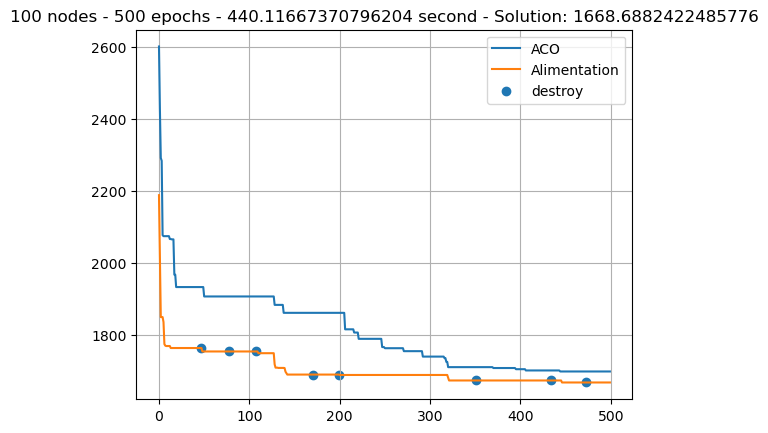

In [9]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(max_iteration), best_data, label = 'ACO')
plt.plot(torch.arange(max_iteration), best_cost_data, label = 'Alimentation')
plt.scatter(torch.tensor(destroy_data), torch.tensor(best_cost_data)[torch.tensor(destroy_data)], label = 'destroy')
plt.title("{} nodes - {} epochs - {} second - Solution: {}".format(cfg.graph_size ,max_iteration, time_run, best_cost))
plt.grid()
plt.legend()

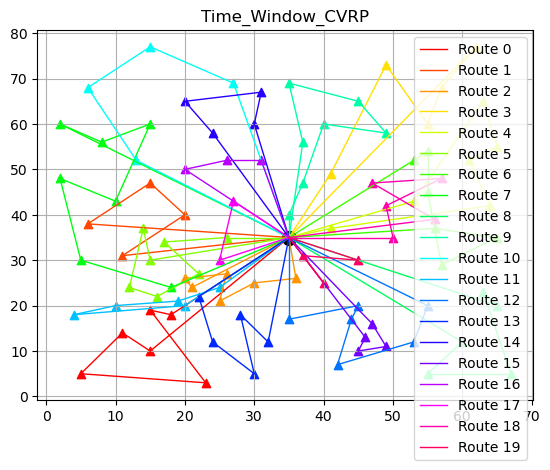

In [10]:
draw(final_path, colony)